# Training Tips and Tricks


### Contents

* [Data Preprocessing](#Data-Preprocessing)
* [Weight and Bias Initialization](#Weight-and-Bias-Initialization)
    * [Xavier-Glorot Initialization](#Xavier-Glorot Initialization)
        * [Xavier Normal](#Xavier-Normal)
        * [Xavier Uniform](#Xavier-Uniform)
    * [Kaiming Normal Initialization](#Kaiming-Normal-Initialization)
    * [Orthogonal Initialization](#Orthogonal-Initialization)
    * [Initialization Visualization](#Initialization-Visualization)
    * [Bias Initialization](#Bias-Initialization)
* [Optimizers](#Optimizers)
    * [Momentum](#Momentum)
    * [Nesterov Momentum](#Nesterov-Momentum)
    * [Adagrad](#Adagrad)
    * [RMSProp](#RMSProp)
    * [Adam](#Adam)
* [Unit Tests before you start training](#Unit-Tests-before-you-start-training)
    * [Correct Loss value](#Correct-Loss-value)
    * [Overfitting test](#Overfitting-test)
    * [Gradient Checks](#Gradient-Checks)
    * [Inspecting the Learning Rate](#Inspecting-the-Learning-Rate)
    * [Learning rate annealing](#Learning-rate-annealing)
* [Putting it all together in MXNet](#Putting-it-all-together)




### Before we get started

Neural Networks, like other Machine Learning and statistical models, benefit heavily from having data pre-processed to get rid of noisey, inconsistant, and incomplete samples.


Please feel free to skip this section if you're familiar with data pre-processing 

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 15,3
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

# Create some fake data
xx = np.array([-.5, .5])
yy = np.array([-.3, 3])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.7        # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
m = np.random.multivariate_normal(means, covs, 1000)

# Data Preprocessing

A few very common techniques are: Zero Centering, Normalizing, PCA, and Whitening

***Zero Centering***: subtracting the mean from the data 

In [2]:
### Zero Centered
meanx = np.mean(m, axis=0)
xx = m - meanx

***Normalizing***: standardizing the data so that all dimensions are on the same scale

In [3]:
### Normalized
stdx = np.std(m, axis = 0)
n = xx / stdx

***Principal Components Analysis***: removes correlation between variables by reducing the data to a set of *n* uncorrelated variables

In [4]:
### PCA
# get the data covariance matrix of the zero-centered data
cov = np.dot(xx.T, xx) / xx.shape[0]
# compute the SVD factorization of the data covariance matrix
U,S,V = np.linalg.svd(cov)
# decorrelate the data
Xrot = np.dot(xx, U)
# Xrot_reduced becomes [N x 100]
Xrot_reduced = np.dot(xx, U[:,:100])

***Whitening***: which reduces correlated variables into a set of *n* uncorrelated variables that all have a variance of 1.  

In [5]:
# whiten the data:
# divide by the eigenvalues (which are square roots of the singular values)
Xwhite = Xrot / np.sqrt(S)

#### Plot the differences

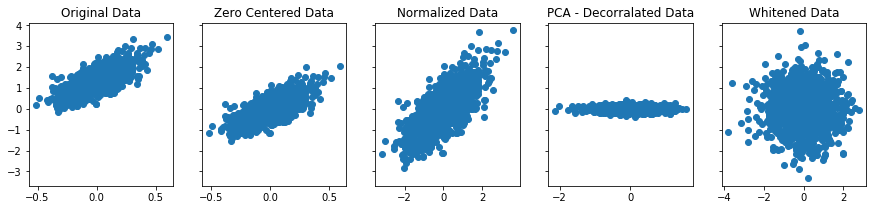

In [6]:
# Plot 
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True)
ax1.plot(m.T[0],m.T[1],'o')
ax1.set_title('Original Data')
ax2.plot(xx.T[0],xx.T[1],'o')
ax2.set_title('Zero Centered Data')
ax3.plot(n.T[0],n.T[1],'o')
ax3.set_title('Normalized Data')
ax4.plot(Xrot_reduced.T[0],Xrot_reduced.T[1],'o')
ax4.set_title('PCA - Decorralated Data')
ax5.plot(Xwhite.T[0],Xwhite.T[1],'o')
ax5.set_title('Whitened Data')


# Weight and Bias Initialization

So far we've initilaized $W$ with random initializations. We want the weights to random and as close to zero as possible without actually being zero. This is because if every neuron is zero,  they will compute the same output with the same gradients during backpropagation and undergo the exact same parameter updates. If the weights in a network start too small, then the signal shrinks as it passes through each layer until it’s too tiny to be useful. If the weights in a network start too large, then the signal grows as it passes through each layer until it’s too massive to be useful. So how do we initialize our weights?

In [7]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 10,3
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
np.random.seed(12)

def return_weight_data(initializer):
    """
    function to show how the mxnet initializers work
    """
    data = mx.symbol.Variable('data')
    weight  = mx.symbol.FullyConnected(data = data, name='weight',
                                       num_hidden=500)
    mlp = mx.symbol.SoftmaxOutput(data=weight, name='softmax')

    # Here we instatiate the model for our data
    model = mx.mod.Module(
        mlp, context = mx.cpu(0), data_names = ['data'],
        label_names = ['softmax_label'],
        )
    # bind the shapes to the module
    model.bind(data_shapes=[['data',(500,500)]], 
               label_shapes=[['softmax_label',(500,)]])
    model.init_params(initializer)
    return model.get_params()[0]['weight_weight'].asnumpy()

### Xavier-Glorot Initialization

**Xavier** initialization makes sure the weights are ‘just right’, keeping the signal in a reasonable range of values through many layers; eg the variance on the input and output to be the exact same; thus there are ***Xavier Normal*** and ***Xavier Uniform*** initialization styles, where the normal simply uses Gaussian initializer while the uniform uses a uniform initializer.  

#### Xavier Normal

In [8]:
def xavier_normal(shape, gain=1.0):
    fan_in, fan_out = shape[0], shape[1]
    std = gain * np.sqrt(2.0 / (fan_in + fan_out))
    return np.random.uniform(0, std, shape)

# xavier_normal mxnet equiv
mx.initializer.Xavier(rnd_type='gaussian', 
                      factor_type='avg', 
                      magnitude=2)

#### Xavier Uniform

In [9]:
def xavier_uniform(shape, gain=1.0):
    fan_in, fan_out = shape[0], shape[1]
    std = gain * np.sqrt(2.0 / (fan_in + fan_out))
    a = np.sqrt(3.0) * std
    return np.random.uniform(-a, a, shape)

# xavier_uniform mxnet equiv
mx.initializer.Xavier(rnd_type='uniform', 
                      factor_type='avg', 
                      magnitude=2)

### Kaiming Normal Initialization

***Kaiming Normal***: Developed for when using ReLUs. A rectifying linear unit is zero for half of its input, so you need to double the size of weight variance to keep the signal’s variance constant.

In [10]:
def kaiming_normal(shape, gain=1.0):
    fan_in = shape[0]
    std = gain * np.sqrt(1.0 / fan_in)
    return np.random.uniform(0, std, shape)
    
# kaiming_normal mxnet equiv
mx.initializer.Xavier(rnd_type='uniform', 
                      factor_type='in', 
                      magnitude=1)

### Orthogonal Initialization

***Orthogonal***: The eigen values of an Orthogonally initialized matrix are one. Because eigenvalues are what dictate the growth or death of a result as we perform repeated matrix multiplication, this helps in vanishing gradients as they don't explode or diminish. This initialization style is heavily used in RNNs.

In [11]:
def orthogonal(shape, gain=1.0):
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.uniform(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    # pick the one with the correct shape
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return gain * q   

# orthogonal mxnet equiv
mx.initializer.Orthogonal()

### Initialization Visualization 

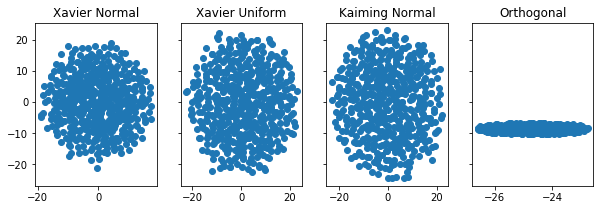

In [12]:
# visualize the layers using Numpy instead of Mxnet
#tsne = TSNE()
#xn = xavier_normal((500,500))
#xn = tsne.fit_transform(xn)
#xu = xavier_uniform((500,500))
#xu = tsne.fit_transform(xu)
#kn = kaiming_normal((500,500))
#kn = tsne.fit_transform(kn)
#o = orthogonal((500,500))
#o = tsne.fit_transform(o)

# visualize the layers as a scatter plot
tsne = TSNE()
xn = return_weight_data(mx.initializer.Xavier(rnd_type='gaussian', 
                      factor_type='avg', 
                      magnitude=2))
xn = tsne.fit_transform(xn)
xu = return_weight_data(mx.initializer.Xavier(rnd_type='uniform', 
                      factor_type='avg', 
                      magnitude=2))
xu = tsne.fit_transform(xu)
kn = return_weight_data(mx.initializer.Xavier(rnd_type='uniform', 
                      factor_type='in', 
                      magnitude=1))
kn = tsne.fit_transform(kn)
o = return_weight_data(mx.initializer.Orthogonal())
o = tsne.fit_transform(o)

#Plot 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.plot(xn[:,0],xn[:,1],'o')
ax1.set_title('Xavier Normal')
ax2.plot(xu[:,0],xu[:,1],'o')
ax2.set_title('Xavier Uniform')
ax3.plot(kn[:,0],kn[:,1],'o')
ax3.set_title('Kaiming Normal')
ax4.plot(o[:,0],o[:,1],'o')
ax4.set_title('Orthogonal')

### Bias Initialization

***Initializing biases***: It is  common to simply use a vector of 0s for the bias initialization.

### Initialization TL;DR

**TL:DR**: If you're using ReLU activations, you should stick with the kaiming-normal initialization


# Optimizers

Going into the details of the various optimizers will be beyond the scope of this workshop; however, it is important to have a general idea of how a select few are different. (for much futher detailed explainations, please see the following list)

>[Advances in optimizing Recurrent Networks by Yoshua Bengio, Section 3.5](http://arxiv.org/pdf/1212.0901v2.pdf)

>[lya Sutskever’s thesis (pdf) contains a longer exposition of the topic in section 7.2](http://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf)

>[Adagrad, Duchi et al.](http://jmlr.org/papers/v12/duchi11a.html)

>[slide 29 of Lecture 6 of Geoff Hinton’s Coursera class](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

>[Adam: A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980)

>[Unit Tests for Stochastic Optimization](http://arxiv.org/abs/1312.6055)

### Momentum

**Momentum (SGD with a momentum parameter)**: This optimization strategy comes from the physical perspective of the optimization problem where one tries to mimic the process of simulating the parameter vector (i.e. a particle) as rolling on a physical landscape. In this view, setting a particle with zero initial velocity at a given location is the equivalent to initializing parameters with random numbers. We relate the force on the particle to the gradient and the force felt on that particle (acceleration) as the negative gradient of the loss function. Basically, this process will begin to build velocity in any direction that has consistent gradient.

In [ ]:
# Momentum update
v = 0.0 # starts at zero
mu = 0.9 #[.5,.9,.99]
v = mu * v - learning_rate * dx # integrate velocity
x += v # integrate position

# mxnet version
mxnet.optimizer.SGD(momentum=0.9)

### Nesterov Momentum

**Nesterov Momentum (NAG - Nesterov Accelerated Gradient)** Differs from regular Momentum in that instead of evaluating the gradient at it's current position, we know that the momentum is going to carry us ahead to a certain position and therefore evaluate the gradient at that position instead (often called the look-ahead position). We know that with Momentum will push the gradient by a given force to a certain location. With Nesterov Momentum we evaluate the gradient at the vicinity of where we know the gradient will go rather than at the current position. In practice, people prefer to use Nesterov Momentum instead of regular Momentum.

In [ ]:
# Nesterov Momentum update
v = 0.0 # starts at zero
mu = 0.9 #[.5,.9,.99]
x_ahead = x + mu * v
# evaluate dx_ahead (the gradient at x_ahead instead of at x)
v = mu * v - learning_rate * dx_ahead
x += v

# mxnet version
mxnet.optimizer.NAG(momentum=0.9)

### Adagrad

**Adagrad**: proposed by [Duchi et al.](http://jmlr.org/papers/v12/duchi11a.html). The thought process here is that the weights that receive high gradients will have their learning rate reduced and weights that receive small or infrequent updates will have their learning rate increased. A downside of this method is that it stops the network from learning due to it's hyper-aggressiveness.

In [ ]:
# Adagrad
# Assume the gradient dx and parameter vector x
eps = 1e-7
cache += dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)

# mxnet version
mxnet.optimizer.Adagrad()

### RMSProp

**RMSProp**: RMSProp adjusts Adagrad by using a moving average of squared gradients instead of squared gradients to reduce Adagrad's aggressive nature. In the code section below, please be sure to compare adagrad and rmsprop. Funnily enough, it has never been published, but instead always cited as [slide 29 of Lecture 6 of Geoff Hinton’s Coursera class](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).  

In [ ]:
#RMSProp
eps = 1e-7
cache = decay_rate * cache + (1 - decay_rate) * dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)

# mxnet version
mxnet.optimizer.RMSProp()

### Adam

**Adam**: Very similar to RMSProp except with a smoothing version of the gradient instead of its raw form. It also uses a bias correction mechanism to compensate for a 'cold-start' that happens before optimizer algorithms fully 'warm-up'. Adam is currently the recommended default algorithm to use.

In [ ]:
#Adam
eps = 1e-8
beta1 = 0.9
beta2 = 0.999
m = 0.0
v = 0.0
m = beta1*m + (1-beta1)*dx # cold-start correction
v = beta2*v + (1-beta2)*(dx**2) # cold-start correction
x += - learning_rate * m / (np.sqrt(v) + eps)

# mxnet version
mxnet.optimizer.Adam()

In the two gifs below, notice the speed of the various optimizers and keep in mind how one would have to augment learning rates to slow or speed up their progression. 


<img src='files/opt1.gif'>


<img src='files/opt2.gif'>


# Unit Tests before you start training

In [2]:
#############################################################
## Set up our mxnet model to showcase the tips and tricks  
#############################################################
%matplotlib inline
import mxnet as mx
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from mxnet.callback import log_train_metric

Setting up a logger is a critical part of MXNet's interface. This logger allows you to receive callbacks on training information as well as error exceptions

In [ ]:
# call our logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Next we define our network. In our network, the 'input' to our computational graph is a symbolic variable for our data, usually this is simply named 'data' as well; symbolic variables are used such that during each iteration of training, a minibatch of data is assigned to that variable for computation. 

The ouput variable here is the SoftmaxOutput symbol. Recall from our Foundations chapter, this a multinomial logistic regression. Within MXNet, the Output variables handle the loss function as well, therefore, we won't need to define our own loss-function for computation

In [ ]:
# Network declaration as symbols.
data = mx.symbol.Variable('data')
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=512)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 512)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
mlp = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')

Now we'll fetch the MNIST dataset and perform PCA on the data to reduce our computational load. We'll also add a bit of noise to the data to make the model more robust to overfitting. After this step, we'll split the data into Training and Testing sets.

In [ ]:
# Now we fetch MNIST dataset, add some noise, 
# permutate, and assign the examples to be used on our network
mnist = fetch_mldata('MNIST original')
mnist_pca = PCA(n_components=70).fit_transform(mnist.data)
noise = np.random.normal(size=mnist_pca.shape)
mnist_pca += noise
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist_pca.shape[0])
X = mnist_pca[p]
Y = mnist.target[p]
X_show = mnist.data[p]

# This is just to normalize the input to a value inside [0,1],
# and separate train set and test set
X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
X_show = X_show[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]

Here we assign our training and testing data to an MXNet specific iterator. This iterator is part of a [number of data iterator objects](http://mxnet.io/api/python/io.html#data-iterators) that are part of the MXNet libarary. After we assign our data to each iterator, we take a step to overwrite the 'name' of the data so there will be no naming collisions within the MXNet computational graph - NOTE: this step is done for versions <= 0.9.4. 

In [ ]:
# set batch size
batch_size = 200
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

# A quick work around to prevent mxnet complaining the lack of a softmax_label (0.9.4 only)
train_iter.label =  mx.io._init_data(Y_train, allow_empty=True, default_name='softmax_label')
test_iter.label =  mx.io._init_data(Y_test, allow_empty=True, default_name='softmax_label')

Lastly, we make use of the <code>mxnet.metric.EvalMetric</code> class that allows us to record feedback on the network we've defined. Here we're using <code>sklearn</code>'s implementation of <code>log_loss</code> in order to record how well our network is performing at each epoch

In [ ]:
# the cross-entropy loss function for mxnet evaluation callback
class LogLoss(mx.metric.EvalMetric):
    def __init__(self):
        self.loss = []
        super(LogLoss, self).__init__('LogLoss')

    def update(self, labels, preds):
        label_weight = labels[0].asnumpy()
        preds = preds[0].asnumpy()
        loss = log_loss(label_weight, preds)
        self.loss.append(loss)
        self.sum_metric += loss
        self.num_inst += 1

## Correct Loss value

The first step we'll take in our Unit-testing is to make sure that we're getting the loss we expect when we define our network. With the MNIST dataset and a Softmax Classifier, for example, we expect the untrained loss to be 2.302. This is because we expect a probability output for 0.1 for each class (10 classes) and because Softmax loss is the negative log probability of the correct class, -ln(0.1) = 2.302. So here we'll test a few initialization strategies to ensure we're picking the correct strategy when we finally start training

In [30]:
def test_init_strategy(strategy, text):
    # Here we instatiate the model for our data
    model = mx.mod.Module(
        mlp,                             # Use the network we just defined
        context = mx.cpu(0),             # Run on CPU 0
        data_names = ['data'],           # Provide the name of 'data'
        label_names = ['softmax_label'], # Provide the name of 'label
        )
    # bind the correct shapes
    model.bind(data_shapes=train_iter.provide_data,
               label_shapes=train_iter.provide_label)

    # manually init the params
    model.init_params(strategy)

    # output the entire test dataset
    output = model.predict(test_iter).asnumpy()
    
    print("Initialization using {}".format(text))
    
    print("Untrained predictions (should be close to .1)")
    print(list(output[0]))
    
    print("Mean prediction {}, prediction std {}".format(np.mean(output),np.std(output)))
    
    data_loss = log_loss(Y_test, output)
    print("Total Data Loss: {}".format(data_loss))
    print("\n")


test_init_strategy(mx.initializer.Xavier(), 'Xavier')

test_init_strategy(mx.initializer.Xavier(rnd_type='uniform', factor_type='in', magnitude=1), 'Kaiming Normal')
    
test_init_strategy(mx.initializer.Orthogonal(0.25), 'Orthogonal - 0.25')



Initialization using Xavier
Untrained predictions (should be close to .1)
[0.10522023, 0.10625023, 0.10988785, 0.089549445, 0.091543011, 0.08146327, 0.077686548, 0.091829546, 0.15389612, 0.092673771]
Mean prediction 0.10000000149, prediction std 0.0244382936507
Total Data Loss: 2.32725609273


Initialization using Kaiming Normal
Untrained predictions (should be close to .1)
[0.10743047, 0.096293211, 0.10858989, 0.093776748, 0.098764867, 0.10363301, 0.093996167, 0.090252951, 0.10381297, 0.10344975]
Mean prediction 0.100000008941, prediction std 0.00731063494459
Total Data Loss: 2.29337943423


Initialization using Orthogonal - 0.25
Untrained predictions (should be close to .1)
[0.10006409, 0.10023994, 0.099764697, 0.099924028, 0.10011359, 0.099741556, 0.1001128, 0.099977002, 0.099773407, 0.10028884]
Mean prediction 0.099999986589, prediction std 0.000210285143112
Total Data Loss: 2.30286796756




## Overfitting test

Before we start training on thefull dataset, we'll try to train on a tiny portion of our data (setting regularization to zero again) and make sure we can achieve zero cost. Before, however, we want to make sure our sample data is error and bug free, otherwise we'll pass this test and not be able to generalize to the larger dataset.  

One should peform the overfitting test prior to each new dataset being tested. Unless we can accomplish zero cost, we don't want to waste our time training a model for weeks only to find out it can't fit the data.

In [ ]:
#############################################################
## This will take a long time ----- so please don't run   ##
#############################################################

def perform_overfitting_test(mlp, X_train, Y_train, batch_size=50):
    # create new dataset from last 100 examples
    overfit_train_iter = mx.io.NDArrayIter(X_train[-100:], Y_train[-100:], batch_size=batch_size)
    # A quick work around to prevent mxnet complaining the lack of a softmax_label
    overfit_train_iter.label =  mx.io._init_data(Y_train[-100:], allow_empty=True, default_name='softmax_label')

    # Here we instatiate the model for our data
    model = mx.mod.Module(
        mlp,                             # Use the network we just defined
        context = mx.cpu(0),             # Run on CPU 0
        data_names = ['data'],           # Provide the name of 'data'
        label_names = ['softmax_label'], # Provide the name of 'label
        )
    # bind the shapes to the module
    model.bind(data_shapes=overfit_train_iter.provide_data,
               label_shapes=overfit_train_iter.provide_label)

    # call fit to make sure you can achieve 0 loss
    model.fit(
        train_data = overfit_train_iter,
        num_epoch = 5000,
        eval_metric = LogLoss(),
        initializer = mx.init.Orthogonal(0.25),
        optimizer_params = {'learning_rate':0.1, 'momentum': 0.9, 'wd':0.00001},
        batch_end_callback = log_train_metric(500),
    )
    
    

## Gradient Checks

It's also very important to peform gradient checks on the model you've built. A gradient check is where one compares the analytic gradient to the numeric gradient. Under the hood, many things are taken care of, but it's important to know why these things are happening:

Gradient checking involes using the **centered difference formula** to evaluate the numeric gradient

   $$\frac{df(x)}{dx} = \frac{f(x + h) - f(x - h)}{2h} \hspace{0.1in}$$

and the **relative error** between the numeric and analytic gradients

$$\frac{\mid f'_a - f'_n \mid}{\max(\mid f'_a \mid, \mid f'_n \mid)}$$

which considers their ratio of the differences to the ratio of the absolute values of both gradients. In practice:

* relative error > 1e-2 usually means the gradient is probably wrong
* 1e-2 > relative error > 1e-4 should make you feel uncomfortable
* 1e-4 > relative error is usually okay for objectives with kinks. But if there are no kinks (e.g. use of tanh nonlinearities and softmax), then 1e-4 is too high.
* 1e-7 and less you should be happy.

The deeper the network, the higher the relative errors will be. For example, a single differentiable function with an error of 1e-2 indicates an incorrect gradient, however, for a deep 100 layer network, a relative error of around 1e-2 might be okay because the errors build up on the way. 

Important points to consider when performing Gradient Checks:

**Use double precision.** Thankfully, MXNet takes care of this for you, but a common mistake in the past that many scientists make is using single precision floating point to compute gradient check. Often, you will get high relative errors, even with a correct gradient implementation.

**Always print the raw numerical/analytic gradient,** and make sure that the numbers you are comparing are not extremely small. Andre Karpathy recommends scaling your loss function by some constant to bring them into what he calls a 'nicer' range where floats are 'more dense' - ideally on the order of 1.0, where your float exponent is 0.

**Beware of non-differentiable parts of an objective function**, introduced by functions such as ReLU (max(0,x). Consider the case of the ReLU (x < 0) if x-=1e6: the analytic gradient is exactly zero. However, the numeric gradient might compute a non-zero gradient if the area during numeric computation crosses over the non-differentiable portion of the function; $f(x+h)$ if $h > 1e-6$.

**Using a few datapoints.**: Using very few datapoints makes your gradient check faster and more efficient.

**Burn in period**. It is best to use a short burn-in period after the network has been allowed to learn and the loss starts to go down. If the gradient check is performed at first iteration, it could mask an incorrect implementation of the gradient.

**Turn off Regularization if you're using it**: a loss function is a sum of the data loss and the regularization loss (e.g. L2 penalty on weights). Sometimes the regularization loss may overwhelm the data loss, in which case the gradients will be primarily coming from the regularization term. This can mask an incorrect implementation of the data loss gradient. Also be sure to turn off dropout/data augmentations.

Lastly, **Make sure to gradient check a few dimensions for every separate parameter**


# ***Thankfully, MXNet (as well as other modern DL libraries) has the above built-in to make gradient checking a lot easier on the user.***

In [ ]:
#############################################################
## This will kill the jupyter kernel -- so please don't run #
#############################################################

from mxnet.test_utils import check_numeric_gradient
from copy import deepcopy


def perform_gradient_test(mlp, X_train, Y_train):
    # create new dataset from last 10 examples
    overfit_train_iter = mx.io.NDArrayIter(X_train[-10:], 
                                           Y_train[-10:], 
                                           batch_size=10)
    
    # A quick work around to prevent mxnet complaining the lack of a softmax_label
    overfit_train_iter.label =  mx.io._init_data(Y_train[-10:], 
                                    allow_empty=True, 
                                    default_name='softmax_label')

    # Here we instatiate the model for our data
    model = mx.mod.Module(
        mlp,                             # Use the network we just defined
        context = mx.cpu(0),             # Run on CPU 0
        data_names = ['data'],           # Provide the name of 'data'
        label_names = ['softmax_label'], # Provide the name of 'label
        )
    # bind the shapes to the module
    model.bind(data_shapes=overfit_train_iter.provide_data,
               label_shapes=overfit_train_iter.provide_label)
    
    # call fit to burn-in the model
    model.fit(
        train_data = overfit_train_iter,
        num_epoch = 500,
        eval_metric = LogLoss(),
        initializer = mx.initializer.Xavier(),
        optimizer_params = {'learning_rate':0.1, 'momentum': 0.9, 'wd':0.00001},
        batch_end_callback = log_train_metric(500),
    )
    
    # copy the model's parameters and inject the variables for 
    # 'data' and 'softmax_label'
    parameters = deepcopy(model.get_params()[0])
    parameters['data'] = overfit_train_iter.getdata()[0]
    parameters['softmax_label'] = overfit_train_iter.getlabel()[0]

    # perform gradient check
    check_numeric_gradient(mlp, parameters)


# you should see something similar to this below if there is something wrong

"""
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<ipython-input-191-150091434937> in <module>()
----> 1 check_numeric_gradient(mlp,parameters)

/Users/krzum/anaconda3/envs/ml/lib/python2.7/site-packages/mxnet-0.9.5-py2.7.egg/mxnet/test_utils.pyc in check_numeric_gradient(sym, location, aux_states, numeric_eps, rtol, atol, grad_nodes, use_forward_train, ctx)
    518         if grad_req[name] == 'write':
    519             assert_almost_equal(fd_grad, sym_grad, rtol, atol,
--> 520                                 ("NUMERICAL_%s"%name, "BACKWARD_%s"%name))
    521         elif grad_req[name] == 'add':
    522             assert_almost_equal(fd_grad, sym_grad - orig_grad, rtol, atol,

/Users/krzum/anaconda3/envs/ml/lib/python2.7/site-packages/mxnet-0.9.5-py2.7.egg/mxnet/test_utils.pyc in assert_almost_equal(a, b, rtol, atol, names)
    149                             % (rel, rtol, atol, str(index), a[index], b[index]),
    150                             names=names)
--> 151     raise AssertionError(msg)
    152 
    153 

AssertionError: 
Items are not equal:
Error 1521893.750000 exceeds tolerance rtol=0.010000, atol=0.000000.  Location of maximum error:(110, 56), a=0.000121, b=-0.000000
 NUMERICAL_data: array([[ 0.00000001, -0.        , -0.00000001, ...,  0.        ,
        -0.        ,  0.00000001],
       [ 0.00000446, -0.00000987,  0.00000123, ...,  0.00000095,...
 BACKWARD_data: array([[-0.        , -0.00000001, -0.        , ..., -0.        ,
         0.        ,  0.        ],
       [ 0.00000526, -0.0000118 ,  0.00000154, ...,  0.00000116,...
"""


## Inspecting the Learning Rate

After we've performed the above steps, the next step is to inspect our loss function to ensure our optimizer and loss function parameters are chosen correctly. It's important to plot the slope of the loss function to ensure the network is learning properly. The below image is a general heuristic we use to evaluate that our initial learning rate is being chosen properly. 

<img src='files/learningrates.jpeg'>

INFO:root:Iter[0] Batch[0] Train-LogLoss=2.302891
INFO:root:Epoch[0] Train-LogLoss=0.535295
INFO:root:Epoch[0] Time cost=1.937
INFO:root:Epoch[0] Validation-LogLoss=0.130427
INFO:root:Iter[1] Batch[0] Train-LogLoss=0.159358
INFO:root:Epoch[1] Train-LogLoss=0.103304
INFO:root:Epoch[1] Time cost=1.901
INFO:root:Epoch[1] Validation-LogLoss=0.087567
INFO:root:Iter[2] Batch[0] Train-LogLoss=0.112749
INFO:root:Epoch[2] Train-LogLoss=0.069140
INFO:root:Epoch[2] Time cost=2.147
INFO:root:Epoch[2] Validation-LogLoss=0.074296


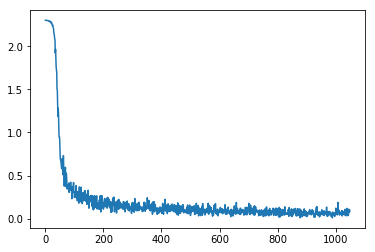

In [9]:
# Here we instatiate the model for our data
model = mx.mod.Module(
    mlp,                             # Use the network we just defined
    context = mx.cpu(0),             # Run on CPU 0
    data_names = ['data'],           # Provide the name of 'data'
    label_names = ['softmax_label'], # Provide the name of 'label
    )
# bind the shapes to the module
model.bind(data_shapes=train_iter.provide_data,
           label_shapes=train_iter.provide_label)

# initialize the logloss evaluation metric
cross_entropy_evaluator = LogLoss()

# call fit to make sure you can achieve 0 loss
model.fit(
    train_data = train_iter,
    eval_data = test_iter,
    num_epoch = 3,
    eval_metric = cross_entropy_evaluator,
    initializer = mx.init.Orthogonal(0.25),
    optimizer_params = {'learning_rate':0.1, 'momentum': 0.9, 'wd':0.00001},
    batch_end_callback = log_train_metric(500),
)

plt.plot(cross_entropy_evaluator.loss)

## Learning rate annealing

After we've established a first learning rate, we must now decide if we put the learning rate on a type of decay-schedule, especially if we have larger models. This is done because sometimes the model is not able to reach the true minimum of the loss due to the step size being large and the gradient not being able to settle down into narrower parts of the loss function. 

One common way people deal with the above problem is to anneal the learning rate is via some sort of step decay where one simply reduces the learning rate every $n$ steps. One simple heuristic is to reduce the learning rate in half when improvement on the validation set stops. Problems can still arise, however. If decay your learning rate too slowly, you'll  proceed with very little improvement in loss reduction as the gradient will bounce around unable to get into the smaller crevasses and if you decay to aggressively, you'll waste computation time simply moving too slowly.

MXNet gives you an easy package to implement your learning rate strategies, found in the <code>mxnet.lr_scheduler.LRScheduler</code> class. In order to implement the common decay strategy, we'll use the <code>FactorScheduler</code> to decay our learning rate by <code>base_lr * pow(factor, floor(num_update/step))</code>

In [ ]:
# Reduce the learning rate by a factor for every *n* steps.
# It returns a new learning rate by::
# base_lr * pow(factor, floor(num_update/step))
lr_scheduler = mx.lr_scheduler.FactorScheduler(
                    step = 5000,
                    factor = 0.1)

# initialize the logloss evaluation metric
cross_entropy_evaluator = LogLoss()

# fit our model
model.fit(
    train_data = train_iter,
    eval_data = test_iter,
    num_epoch = 10,
    eval_metric = cross_entropy_evaluator,
    initializer = mx.init.Orthogonal(0.25),
    optimizer_params = {'learning_rate':0.1, 'momentum': 0.9,
                        ##### Learning Rate Sheduling ######
                        'lr_scheduler': lr_scheduler},
    batch_end_callback = log_train_metric(500),
)

# Putting it all together

Below is a full implementation of the all the steps we've discussed so far.

INFO:root:Iter[0] Batch[0] Train-LogLoss=2.302969
INFO:root:Epoch[0] Train-LogLoss=0.360535
INFO:root:Epoch[0] Time cost=5.490
INFO:root:Epoch[0] Validation-LogLoss=0.121222
INFO:root:Iter[1] Batch[0] Train-LogLoss=0.130813
INFO:root:Epoch[1] Train-LogLoss=0.094354
INFO:root:Epoch[1] Time cost=4.320
INFO:root:Epoch[1] Validation-LogLoss=0.082275
INFO:root:Iter[2] Batch[0] Train-LogLoss=0.096660
INFO:root:Epoch[2] Train-LogLoss=0.060938
INFO:root:Epoch[2] Time cost=8.021
INFO:root:Epoch[2] Validation-LogLoss=0.073913
INFO:root:Iter[3] Batch[0] Train-LogLoss=0.075060
INFO:root:Epoch[3] Train-LogLoss=0.042938
INFO:root:Epoch[3] Time cost=5.375
INFO:root:Epoch[3] Validation-LogLoss=0.069780
INFO:root:Iter[4] Batch[0] Train-LogLoss=0.058862
INFO:root:Epoch[4] Train-LogLoss=0.030366
INFO:root:Epoch[4] Time cost=3.296
INFO:root:Epoch[4] Validation-LogLoss=0.066718
INFO:root:Iter[5] Batch[0] Train-LogLoss=0.038986
INFO:root:Epoch[5] Train-LogLoss=0.021025
INFO:root:Epoch[5] Time cost=3.871
INF

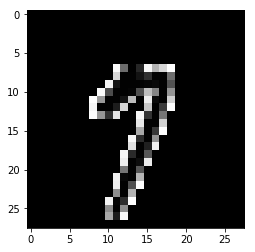

Predicted Result: 7


In [34]:
#############################################################
## Set up our mxnet model to showcase the tips and tricks  ##
#############################################################
%matplotlib inline
import mxnet as mx
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from mxnet.callback import log_train_metric

# call our logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Network declaration as symbols.
data = mx.symbol.Variable('data')
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=512)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 512)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
mlp = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')

# Now we fetch MNIST dataset, add some noise, 
# permutate, and assign the examples to be used on our network
mnist = fetch_mldata('MNIST original')
mnist_pca = PCA(n_components=70).fit_transform(mnist.data)
noise = np.random.normal(size=mnist_pca.shape)
mnist_pca += noise
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist_pca.shape[0])
X = mnist_pca[p]
Y = mnist.target[p]
X_show = mnist.data[p]

# This is just to normalize the input to a value inside [0,1],
# and separate train set and test set
X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
X_show = X_show[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]

# set batch size
batch_size = 200
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

# A quick work around to prevent mxnet complaining the lack of a softmax_label (0.9.4 only)
train_iter.label =  mx.io._init_data(Y_train, allow_empty=True, default_name='softmax_label')
test_iter.label =  mx.io._init_data(Y_test, allow_empty=True, default_name='softmax_label')

# the cross-entropy loss function for mxnet evaluation callback
class LogLoss(mx.metric.EvalMetric):
    def __init__(self):
        self.loss = []
        super(LogLoss, self).__init__('LogLoss')

    def update(self, labels, preds):
        label_weight = labels[0].asnumpy()
        preds = preds[0].asnumpy()
        loss = log_loss(label_weight, preds)
        self.loss.append(loss)
        self.sum_metric += loss
        self.num_inst += 1


# Here we instatiate the model for our data
model = mx.mod.Module(
    mlp,                             # Use the network we just defined
    context = mx.cpu(0),             # Run on CPU 0
    data_names = ['data'],           # Provide the name of 'data'
    label_names = ['softmax_label'], # Provide the name of 'label
    )

# bind the shapes to the module
model.bind(data_shapes=train_iter.provide_data,
           label_shapes=train_iter.provide_label)

# initialize the logloss evaluation metric
cross_entropy_evaluator = LogLoss()

# learning rate scheduler            
lr_scheduler = mx.lr_scheduler.FactorScheduler(
                    step = 5000,
                    factor = 0.1)

# fit the model - notice the first loss is 
#"INFO:root:Iter[0] Batch[0] Train-LogLoss=2.302969", right where
# we want it to be
model.fit(
    train_data = train_iter,                    # Define training data
    eval_data = test_iter,                      # Define testing/evaluation data
    num_epoch = 11,                             # 10 training epochs
    eval_metric = cross_entropy_evaluator,      # use Cross Entropy as the eval metric
    initializer = mx.init.Orthogonal(0.25),     # Use an Orthogonal initializer for our weights
    optimizer = 'adam',                         # Use Adam as our optimizer
    optimizer_params = {                        # Define our optimizer's params
        'learning_rate':0.0009,                 # Start the learning rate at .1
        'wd':0.00001,                           # Set the weight decay
        'lr_scheduler': lr_scheduler            # User our learning rate scheduler
    },
    batch_end_callback = log_train_metric(500), # Use the callback function to tell us 
)                                               # how well the model is performing after each epoch

# show the data
plt.imshow((X_show[0].reshape((28,28))*255).astype(np.uint8), cmap='Greys_r')
plt.show()
print('Predicted Result: {}'.format(model.predict(test_iter)[0].asnumpy().argmax()))